## Simple H2O AutoML Baseline:

* Add original data
* Add location with reverse geocoder
* Run AutoML


In [1]:
!pip install h2o

     |████████████████████████████████| 177.5 MB 107.7 MB/s eta 0:00:01
  Created wheel for h2o: filename=h2o-3.38.0.4-py2.py3-none-any.whl size=177628724 sha256=4226ad9864909e1e593a2361b46e396846849a97d0bb070b54fda27ef399fc2a
  Stored in directory: /Users/zhenningli/Library/Caches/pip/wheels/54/fb/dc/8343ac4dd86ad7753e399482d071ff3e51c8f8b4fdf0803c92
Successfully built h2o


In [2]:
import pandas as pd
import h2o
from h2o.automl import H2OAutoML
from sklearn.datasets import fetch_california_housing

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

### Data preparation

In [4]:
external_data = fetch_california_housing()
train2 = pd.DataFrame(external_data['data'])
train2['target'] = external_data['target']
train2.columns = train_df.columns[1:]
train_df = pd.concat([train_df, train2]).drop_duplicates()

In [5]:
!pip install reverse_geocoder

     |████████████████████████████████| 2.2 MB 22.6 MB/s eta 0:00:01
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268068 sha256=4698625c8756748a02637d4ed01724843ef570d8f85cb4543e3b9a9d0c256037
  Stored in directory: /Users/zhenningli/Library/Caches/pip/wheels/10/05/be/d2edd4ff207cf625ce8bd20cf1493c27838828e8920aff9f4e
Successfully built reverse-geocoder


In [6]:
import reverse_geocoder as rg

for df in [train_df,test_df]:
    coordinates = list(zip(df['Latitude'], df['Longitude']))
    results = rg.search(coordinates)
    df['county'] = [x['admin2'] for x in results]
    df['place'] = [x['name'] for x in results]

Loading formatted geocoded file...


### Auto ML

In [7]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_341"; Java(TM) SE Runtime Environment (build 1.8.0_341-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.341-b10, mixed mode)
  Starting server from /Users/zhenningli/opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/80/c06srb3s01d38_4p8dxz4twr0000gn/T/tmp6ldoa6_n
  JVM stdout: /var/folders/80/c06srb3s01d38_4p8dxz4twr0000gn/T/tmp6ldoa6_n/h2o_zhenningli_started_from_python.out
  JVM stderr: /var/folders/80/c06srb3s01d38_4p8dxz4twr0000gn/T/tmp6ldoa6_n/h2o_zhenningli_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_zhenningli_1zz395
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,14.20 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


In [8]:
train_h2o = h2o.H2OFrame(train_df)
test_h2o = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [9]:
target = 'MedHouseVal'
features = train_df.columns.drop([target,'id','Population']).to_list()

aml = H2OAutoML(max_runtime_secs=5000, seed=11,nfolds=10)
aml.train(x=features, y=target, training_frame=train_h2o);

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


In [10]:
aml.leaderboard

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20230108_152508,0.515287,0.265521,0.35077,0.154148,0.265521
StackedEnsemble_AllModels_4_AutoML_1_20230108_152508,0.515331,0.265566,0.350818,0.154159,0.265566
StackedEnsemble_AllModels_5_AutoML_1_20230108_152508,0.51854,0.268884,0.359799,0.155757,0.268884
StackedEnsemble_AllModels_2_AutoML_1_20230108_152508,0.519277,0.269648,0.353841,0.155211,0.269648
StackedEnsemble_AllModels_1_AutoML_1_20230108_152508,0.51938,0.269756,0.353959,0.155254,0.269756
StackedEnsemble_BestOfFamily_4_AutoML_1_20230108_152508,0.519391,0.269767,0.354221,0.155392,0.269767
StackedEnsemble_BestOfFamily_5_AutoML_1_20230108_152508,0.519851,0.270245,0.354071,0.155288,0.270245
StackedEnsemble_BestOfFamily_3_AutoML_1_20230108_152508,0.521472,0.271933,0.35511,0.155691,0.271933
StackedEnsemble_BestOfFamily_2_AutoML_1_20230108_152508,0.52163,0.272098,0.355245,0.155752,0.272098
StackedEnsemble_BestOfFamily_1_AutoML_1_20230108_152508,0.522644,0.273157,0.356987,0.156247,0.273157


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

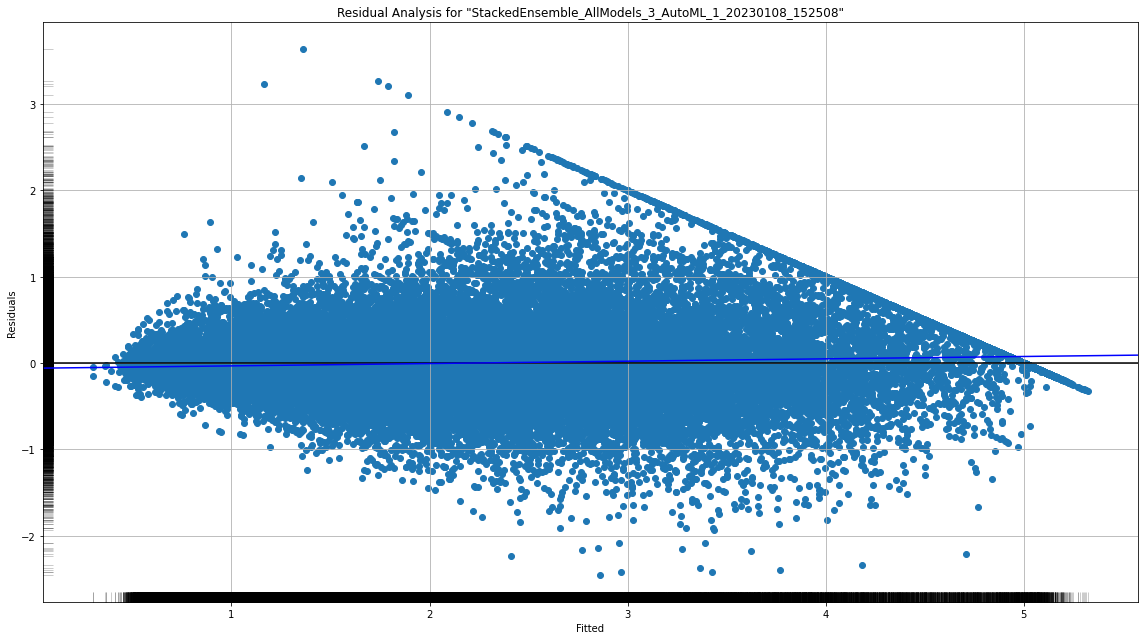

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

In [11]:
aml.leader.explain(train_h2o,include_explanations=['residual_analysis'])

### Submission

In [12]:
sub[target] = aml.leader.predict(test_h2o).as_data_frame()
sub.to_csv("Auto_ml_submission别人的.csv", index=False)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/zhenningli/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'county' has levels not trained on: ["Esmeralda County"]
  warnings.warn(w)
/Users/zhenningli/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'place' has levels not trained on: ["Goldfield", "Yerington"]
  warnings.warn(w)


In [13]:
sub.describe()

,id,MedHouseVal
count,24759.000000,24759.000000
mean,49516.000000,2.077143
std,7147.451994,1.026969
min,37137.000000,0.444074
25%,43326.500000,1.304390
50%,49516.000000,1.887935
75%,55705.500000,2.649078
max,61895.000000,5.288844


In [14]:
sub.head()

,id,MedHouseVal
0,37137,0.701007
1,37138,1.047038
2,37139,4.359730
3,37140,3.250470
4,37141,2.481970
